In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Input, Embedding, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, MaxPool1D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
# creates a model that categorizes text as 'spam' or 'non-spam'
# Training dataset: 3565 samples, validation: 892
# achieves 0.9846 validation acuuracy with 0.0712 validation loss on the second epoch, after which it is showing signs of overfitting
# LSTM vs CNN on the same language task
#         ACCURACY | LOSS
#    LSTM    0.9817| 0.0548 (2nd epoch)
# .  CNN     0.9846| 0.0712 (2nd epoch)

# what will happen if CNN used for language tasks?
# Instead of image pixels, the input is sentences represented as a matrix. Each row of the matrix corresponds to one-word vector.
# As opposed to RNN, Conv1D feature detector will slide vertically across the data for the convolution

In [3]:
EPOCHS = 10

In [4]:
# READ SPAM DATA
data = pd.read_csv('data/text/spam.csv',delimiter=',',encoding='latin-1', usecols=['v1', 'v2'])
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
text = data['v2'].values
labels = [1 if x == "spam" else 0 for x in data['v1'].values]

In [6]:
#CREATE TRAINING AND TEST DATASETS
MAX_WORDS_IN_SEQ = 1000
EMBED_DIM = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word2index = tokenizer.word_index

num_words = len(word2index)
print(f"Found {num_words} unique tokens")

data = sequence.pad_sequences(sequences, maxlen=MAX_WORDS_IN_SEQ, padding='post', truncating='post')
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

Found 8920 unique tokens


In [7]:
#CREATE MODEL
def CNN():
    model = Sequential()
    # It requires that the input data be integer encoded, so that each word is represented by a unique integer. 
    # This data preparation step can be performed using the Tokenizer API also provided with Keras.
    # The Embedding layer is initialized with random weights and will learn an embedding for all of 
    # the words in the training dataset.
    model.add(Embedding(input_dim=num_words+1, output_dim=EMBED_DIM, input_length=MAX_WORDS_IN_SEQ))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(3))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = CNN()


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         892100    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 128)          38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 332, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 332, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 128)          49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [10]:
history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=32,
                    validation_split=0.2,
                   verbose=1)

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 161s 52ms/step - loss: 0.4577 - acc: 0.8561 - val_loss: 0.4134 - val_acc: 0.8628
Epoch 2/10
3120/3120 [==============================] - 164s 53ms/step - loss: 0.1806 - acc: 0.9353 - val_loss: 0.0508 - val_acc: 0.9795
Epoch 3/10
3120/3120 [==============================] - 165s 53ms/step - loss: 0.0349 - acc: 0.9917 - val_loss: 0.0345 - val_acc: 0.9910
Epoch 4/10
3120/3120 [==============================] - 165s 53ms/step - loss: 0.0200 - acc: 0.9965 - val_loss: 0.0583 - val_acc: 0.9795
Epoch 5/10
3120/3120 [==============================] - 170s 54ms/step - loss: 0.0070 - acc: 0.9990 - val_loss: 0.0447 - val_acc: 0.9897
Epoch 6/10
3120/3120 [==============================] - 164s 53ms/step - loss: 0.0070 - acc: 0.9994 - val_loss: 0.0648 - val_acc: 0.9846
Epoch 7/10
3120/3120 [==============================] - 172s 55ms/step - loss: 0.0093 - acc: 0.9987 - val_loss: 0.0369 - val_acc: 0

In [11]:
#model.save_weights('models/cnn_text_10_epochs.h5') # save model

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

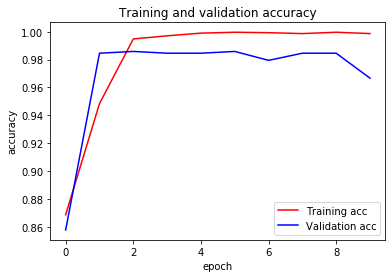

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

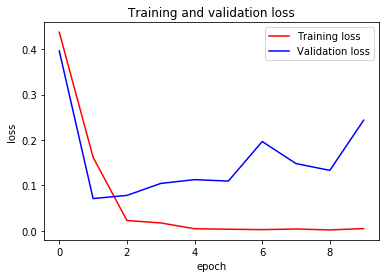

In [69]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [70]:
new_message = ['Free tickets to any concert - call us for more information.']
sequences = tokenizer.texts_to_sequences(new_message)
padded = sequence.pad_sequences(sequences, maxlen=1000)
pred = model.predict(padded)
print(pred)

print('spam' if pred[0][0] > 0.3 else 'non-spam')

[[1.]]
spam


In [72]:
new_message = ['Howdy brother!' ]
sequences = tokenizer.texts_to_sequences(new_message)
padded = sequence.pad_sequences(sequences, maxlen=1000)
pred = model.predict(padded)
print(pred)

print('spam' if pred[0][0] > 0.3 else 'non-spam')

[[0.24509506]]
non-spam
